In [1]:
import os
import pandas as pd
import numpy as np
import warnings
from pathlib import Path
from keras.models import load_model
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
EPOCHS                  = 100   # Nombre d'epoch
IMGSIZE                 = 96    # Taille des images
BATCH_SIZE              = 32    # Pour le traitement par lot des images (optimisation de la decente de gradient)
STOPPING_PATIENCE       = 10    # Callback pour stopper si le modèle n'apprend plus
VERBOSE                 = 0     # Niveau de verbosité
MODEL_NAME              = 'cnn_80epochs_imgsize160'
OPTIMIZER               = 'adam'
pathtrain               = r'C:\Users\chole\Documents\Ynov\Machine Learning 2025\Projet groupe\archive\PokemonData'
#pathtest                = r'C:\Users\chole\Documents\Ynov\Ydays\test'
TRAINING_DIR            = pathtrain
#TEST_DIR                = pathtest
TRAIN_MODEL             = True  # Entrainement du modele (True) ou chargement (False)

In [3]:
train_files = []
train_labels = []

for folder in os.listdir(TRAINING_DIR):
    folder_path = os.path.join(TRAINING_DIR, folder)

    if os.path.isdir(folder_path):  
        for file in os.listdir(folder_path):  
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):  
                train_files.append(file)  # On met juste le nom de l'image, sans le chemin complet
                train_labels.append(folder)  # Le label est le nom du dossier

# Créer le DataFrame
df_train = pd.DataFrame({"id": train_files, "label": train_labels})

# Afficher les premières lignes pour vérifier
print(df_train.head(-5))


                  id    label
0         Abo.01.jpg      Abo
1         Abo.02.jpg      Abo
2         Abo.03.jpg      Abo
3         Abo.04.jpg      Abo
4         Abo.05.jpg      Abo
...              ...      ...
6475  Voltorb.46.jpg  Voltorb
6476  Voltorb.47.jpg  Voltorb
6477  Voltorb.48.jpg  Voltorb
6478  Voltorb.49.jpg  Voltorb
6479  Voltorb.50.jpg  Voltorb

[6480 rows x 2 columns]


In [4]:
from tensorflow.keras.preprocessing import image
import os
import numpy as np

# Dictionnaire qui associe chaque Pokémon à son label (indice)
pokemon_dict = {nom: i for i, nom in enumerate(sorted(os.listdir(TRAINING_DIR))) if os.path.isdir(os.path.join(TRAINING_DIR, nom))}

# Charger et redimensionner les images à une taille cohérente (par exemple 128x128)
images = []
labels = []

# Chargement des images et labels
for _, row in df_train.iterrows():
    img_path = os.path.join(TRAINING_DIR, row['label'], row['id'])
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0  # Normalisation des pixels entre 0 et 1
    images.append(img_array)
    
    # Utilisation du dictionnaire pour obtenir le label correspondant au Pokémon
    label = pokemon_dict.get(row['label'], -1)  # Si l'étiquette n'est pas trouvée, retourne -1
    labels.append(label)

# Convertir les listes en tableaux numpy
images = np.array(images)
labels = np.array(labels)

# Vérification des dimensions
print(images.shape, labels.shape)



(6485, 128, 128, 3) (6485,)


In [5]:
# Dictionnaire qui associe chaque Pokémon à son label (indice)
pokemon_dict = {nom: i for i, nom in enumerate(sorted(os.listdir(TRAINING_DIR))) if os.path.isdir(os.path.join(TRAINING_DIR, nom))}
print (pokemon_dict)

{'Abo': 0, 'Akwakwak': 1, 'Alakazam': 2, 'Amonistar': 3, 'Amonita': 4, 'Aquali': 5, 'Arcanin': 6, 'Articodin': 7, 'Aspicot': 8, 'Aéromite': 9, 'Boustiflor': 10, 'Bulbizarre': 11, 'Canarticho': 12, 'Caninos': 13, 'Carabaffe': 14, 'Carapuce': 15, 'Chenipan': 16, 'Chetiflor': 17, 'Chrysacier': 18, 'Coconfort': 19, 'Colossinge': 20, 'Crustabri': 21, 'Dardargnan': 22, 'Dodrio': 23, 'Doduo': 24, 'Dracaufeu': 25, 'Draco': 26, 'Dracoloss': 27, 'Ectoplasma': 28, 'Electhor': 29, 'Electrode': 30, 'Elektek': 31, 'Empiflor': 32, 'Evoli': 33, 'Excelangue': 34, 'Fantominus': 35, 'Feunard': 36, 'Flagadoss': 37, 'Florizarre': 38, 'Férosinge': 39, 'Galopa': 40, 'Goupix': 41, 'Gravalanch': 42, 'Grodoudou': 43, 'Grotadmorv': 44, 'Herbizarre': 45, 'Hypnomade': 46, 'Hypocéan': 47, 'Hypotrempe': 48, 'Insécateur': 49, 'Kabuto': 50, 'Kabutops': 51, 'Kadabra': 52, 'Kangourex': 53, 'Kicklee': 54, 'Kokiyas': 55, 'Krabboss': 56, 'Krabby': 57, 'Lamantine': 58, 'Leveinard': 59, 'Lippoutou': 60, 'Lokhlass': 61, 'Lévi

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

# Encoder les labels en one-hot
labels = to_categorical(labels, num_classes=145)

# Définir le modèle
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(145, activation='softmax')  # Sortie multi-classes avec softmax
])

# Compiler le modèle pour la classification multi-classes
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])


C:\Users\chole\AppData\Roaming\Python\Python39\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
from sklearn.model_selection import train_test_split

# Diviser les données en train et validation
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

# Entraîner le modèle
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    validation_data=(X_val, y_val)
)

# Évaluation du modèle
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 115s 672ms/step - accuracy: 0.0136 - loss: 4.9196 - val_accuracy: 0.0840 - val_loss: 4.2175
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 664ms/step - accuracy: 0.0955 - loss: 4.0471 - val_accuracy: 0.2552 - val_loss: 3.1952
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 110s 674ms/step - accuracy: 0.2508 - loss: 3.0547 - val_accuracy: 0.3770 - val_loss: 2.5643
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 109s 669ms/step - accuracy: 0.4564 - loss: 2.1104 - val_accuracy: 0.4618 - val_loss: 2.1971
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 665ms/step - accuracy: 0.6138 - loss: 1.4609 - val_accuracy: 0.5212 - val_loss: 1.9754
Epoch 6/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 108s 662ms/step - accuracy: 0.7139 - loss: 1.0309 - val_accuracy: 0.5173 - val_loss: 2.1160
Epoch 7/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 145s 674ms/step - accuracy: 0.7761 - loss: 0.7402 - val_accuracy: 0.5243 - val_loss: 2.0479
Epoch 8/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 141s 663ms/step - accuracy: 0.8485 -

In [11]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing import image
import numpy as np

# Dictionnaire des classes avec l'indice du Pokémon
pokemon_dict = {
    'Abo': 0, 'Akwakwak': 1, 'Alakazam': 2, 'Amonistar': 3, 'Amonita': 4, 'Aquali': 5, 'Arcanin': 6,
    'Articodin': 7, 'Aspicot': 8, 'Aéromite': 9, 'Boustiflor': 10, 'Bulbizarre': 11, 'Canarticho': 12,
    'Caninos': 13, 'Carabaffe': 14, 'Carapuce': 15, 'Chenipan': 16, 'Chetiflor': 17, 'Chrysacier': 18,
    'Coconfort': 19, 'Colossinge': 20, 'Crustabri': 21, 'Dardargnan': 22, 'Dodrio': 23, 'Doduo': 24,
    'Dracaufeu': 25, 'Draco': 26, 'Dracoloss': 27, 'Ectoplasma': 28, 'Electhor': 29, 'Electrode': 30,
    'Elektek': 31, 'Empiflor': 32, 'Evoli': 33, 'Excelangue': 34, 'Fantominus': 35, 'Feunard': 36,
    'Flagadoss': 37, 'Florizarre': 38, 'Férosinge': 39, 'Galopa': 40, 'Goupix': 41, 'Gravalanch': 42,
    'Grodoudou': 43, 'Grotadmorv': 44, 'Herbizarre': 45, 'Hypnomade': 46, 'Hypocéan': 47, 'Hypotrempe': 48,
    'Insécateur': 49, 'Kabuto': 50, 'Kabutops': 51, 'Kadabra': 52, 'Kangourex': 53, 'Kicklee': 54,
    'Kokiyas': 55, 'Krabboss': 56, 'Krabby': 57, 'Lamantine': 58, 'Leveinard': 59, 'Lippoutou': 60,
    'Lokhlass': 61, 'Léviator': 62, 'Machoc': 63, 'Machopeur': 64, 'Mackogneur': 65, 'Magicarpe': 66,
    'Magmar': 67, 'Magneton': 68, 'Magnéti': 69, 'Mew': 70, 'Mewtwo': 71, 'Miaouss': 72, 'Mimitoss': 73,
    'Minidraco': 74, 'MrMime': 75, 'Mystherbe': 76, 'Mélodelfe': 77, 'Mélofée': 78, 'Métamorphe': 79,
    'Nidoking': 80, 'Nidoqueen': 81, 'Nidorina': 82, 'Nidorino': 83, 'Noadkoko': 84, 'Noeunoeuf': 85,
    'Nosferalto': 86, 'Nosferapti': 87, 'Onix': 88, 'Ortide': 89, 'Ossatueur': 90, 'Osselait': 91,
    'Otaria': 92, 'Paras': 93, 'Parasect': 94, 'Persian': 95, 'Piafabec': 96, 'Pikachu': 97, 'Poissirène': 98,
    'Poissoroy': 99, 'Ponyta': 100, 'Porygon': 101, 'Psykokwak': 102, 'Ptitard': 103, 'Ptéra': 104,
    'Pyroli': 105, 'Racaillou': 106, 'Rafflesia': 107, 'Raichu': 108, 'Ramoloss': 109, 'Rapasdepic': 110,
    'Rattata': 111, 'Rattatac': 112, 'Reptincel': 113, 'Rhinocorne': 114, 'Rhinoféros': 115, 'Rondoudou': 116,
    'Ronflex': 117, 'Roucarnage': 118, 'Roucool': 119, 'Roucoups': 120, 'Sabelette': 121, 'Sablaireau': 122,
    'Salamèche': 123, 'Saquedeneu': 124, 'Scarabrute': 125, 'Smogo': 126, 'Smogogo': 127, 'Soporifik': 128,
    'Spectrum': 129, 'Stari': 130, 'Staross': 131, 'Sulfura': 132, 'Tadmorv': 133, 'Tartard': 134,
    'Taupiqueur': 135, 'Tauros': 136, 'Tentacool': 137, 'Tentacruel': 138, 'Tortank': 139, 'Triopikeur': 140,
    'Tygnon': 141, 'Tétarte': 142, 'Voltali': 143, 'Voltorb': 144
}

# Liste des classes que le modèle peut prédire (à partir des clés du dictionnaire)
classes = list(pokemon_dict.keys())

# Fonction pour prédire l'image et afficher la classe correspondante
def predict_image(filepath, model):
    # Charger et redimensionner l'image
    img = image.load_img(filepath, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0  # Normalisation des pixels entre 0 et 1
    img_array = np.expand_dims(img_array, axis=0)  # Ajouter une dimension pour le batch

    # Afficher l'image
    img_to_show = mpimg.imread(filepath)
    plt.imshow(img_to_show)
    plt.axis('off')  # Pour masquer les axes
    plt.show()

    # Faire la prédiction
    prediction = model.predict(img_array)
    
    # Trouver l'indice de la classe avec la probabilité la plus élevée
    predicted_class_index = np.argmax(prediction, axis=1)[0]
    predicted_class_probability = prediction[0][predicted_class_index]

    # Afficher la classe avec la probabilité

    #if predicted_class_probability > 0.8 :
    print(f"Prédiction : {classes[predicted_class_index]} avec une probabilité de {predicted_class_probability:.2f}")
    #else:
        #print ("Un autre pokémon.")




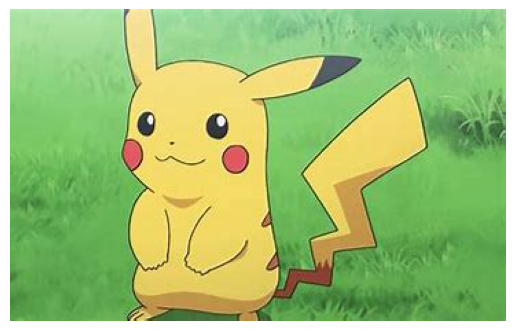

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
Prédiction : Pikachu avec une probabilité de 0.32


In [23]:
predict_image('Pikachu2.jpg', model)